In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./STUFF/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH222

# Studying the solvation shell of ions via Molecular Dynamics Simulations

In this computational experiment you will use **molecular dynamics simulations** to investigate the solvation shell of ions at the atomistic level. For this computer experiment the ions and the solvent particles will be represented by relatively simple models (more on that later), and you will examine how the size of the cation and the temperature effect the structure of the solvation shell.

You will use the Python-based Jupyter Notebook framework, leveraging Statistical Mechanics to compute structural features of this system.

This notebook outlines how to set up the MD simulation using the HOOMD-blue simulation package, and some tips on using the Atomic Simulation Environment (ASE) for handling atomic configurations.

You can find further help, features and options on the Manual pages:  
[HOOMD-blue page](https://hoomd-blue.readthedocs.io/en/stable/index.html)  
[ASE page](https://wiki.fysik.dtu.dk/ase/index.html)

<div class=warn>
Tasks, where you need to edit the code cells will be shown in similar "blue boxes".
<div/>

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

## Content of this notebook

#### Setting up the simulation (this Notebook)

1. Import necessary libraries and initialise HOOMD
2. Set simulation parameters
3. Create initial configuration
4. Initialise the MD engine
5. Set the output format - output file and logged quantities
6. Perform the MD simulation - hoomd.run()

#### Part 2 ("M15_Part.2_ANALYSIS.ipynb" Notebook) Analysing the results

7. Analysing results

## 1. Import necessary libraries and initialise HOOMD

In [2]:
import hoomd
import hoomd.md
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import numpy as np
from matplotlib import pyplot 
import ase # Atomic simulation environment
import ase.io
from ase.visualize import view
#packages necessary to visualise the trajectories
import pytraj as pt 
import nglview as nv

hoomd.context.initialize('--mode=cpu')

def save_config(hoomd_system,atom_types={"Cation":"C","Solvent":"S","Anion":"Ar"}):
    
    lattice=np.array([hoomd_system.box.get_lattice_vector(i=i) for i in range(3)])
    
    pos=[system.particles[i].position for i in range(hoomd_system.particles.types.pdata.getN())]
    types=[atom_types[system.particles[i].type] for i in range(hoomd_system.particles.types.pdata.getN())]
    ase_atoms = ase.Atoms(pbc=(True,True,True),cell=lattice,positions=pos, symbols=types)
    
    ase_atoms.wrap()
    return ase_atoms

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 12/16/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


## 2. Set simulation parameters
Set the values for the size of the system, potential parameters, temperature, pressure...etc.
(A note about the units: since we use the Lennard-Jones potential, the sigma parameter controls the lengthscale of the simulation, the epsilon parameter the energy. Although we could simple work in these Lennard-Jones units, for the sake of easy interpretation we use units and values that feel natural in an atomic system.) 

<div class=warn>
Set the initial box length and the number of solvents below. Note: do not deviate too much from the original values, in order to avoid very high/low densities. </div>

In [3]:
boxL=21 # Angstrom
N_solvent=70 # number of solvents per ion pair

temperature= 0.8 #0.8 # in units of kT
pressure=       0.1 # in units of kJ/mol/Angstrom^3 which is approximatly 160 MPa 
timestep=0.5    # length of one timestep in units of femtosecond 

solvent_sigma=1.0 # Angstrom
solvent_epsilon=1.0 # kJ/mol

anion_sigma=    1.0 # Angstrom
anion_epsilon=  1.0 # kJ/mol

cation_sigma=   2.0 # Angstrom
cation_epsilon= 1.0 # kJ/mol

## 3. Create initial configuration

First we need to create the **inital configuration** for the simulation to start from: 
We create an initial cubic cell with randomly positioned atoms, then replicate this cell in each Cartesian direction (3 times) to create our actual simulation box.

(Note: You can define the system only once, thus you can execute the code cell below only once. If you want to experiment with different setups, you need to restart the kernel or initialize the hoomd.context again!)

In [4]:
position=[]
type_name=[]
charge=[]
mass=[]

#Add one cation
position.append([0.0, 0.0, 0.0])
type_name.append('Cation')
charge.append(1.0)
mass.append(1.0)
    
#Add one anion    
position.append([3.0, 3.0, 3.0])
type_name.append('Anion')
charge.append(-1.0)
mass.append(1.0)

boxL=boxL/3.0
#Add solvent particles
for i in range(N_solvent):
    #print("Adding atom", i, "of",N_solvent)
    generate_new=True
    while generate_new: 
        trial=np.random.rand(3)*(boxL-1.0)
        generate_new=False
        for j in range(i+2):
            if (np.linalg.norm(position[j]-trial)<1.0):
                generate_new=True
    position.append(trial)
    type_name.append('Solvent')
    charge.append(0.0)
    mass.append(1.0)
    
#Create the initial cell    
initial_cell = hoomd.lattice.unitcell(N = N_solvent+2, # number of atoms in the initial cell
                a1 = [boxL,0,0],
                a2 = [0,boxL,0],
                a3 = [0,0,boxL], # these define a cubic box of length boxL 
                position = position, # set positions for the two atoms (they should not be placed on top of each other)
                type_name = type_name,
                charge = charge,
                mass = mass,  
                            );

#Using the initial cell as a building block, create a larger cell. This one will be used for the simulation.
system=hoomd.init.create_lattice(initial_cell,n=3) 

notice(2): Group "all" created containing 1944 particles


<div class=warn>
Now it's time to have a look at our system - It's always a good idea to see what we have created!  </div>

We need a "topology file" (a single configuration of the system containing information about which and how many atoms we have, the simulation box, etc...) and a "trajectory file", which contains information about the time evolution of the system. 

HOOMD writes the trajectory file as a binary .dcd file. In order to write the topology file, we will make use of the Atomic Simulation Environment (ASE) instead. The short ``save_config`` function (included at the beginning of the notebook) extracts the simulation box parameters and the atomic coordinates from the hoomd ``system`` we have defined, and creates an atoms object from it. 

**Note:** ASE expects real atomic symbols as atom types, thus e.g. ``Solvent`` will not work. Hence, we will call our particle types S (solvent), C (Cation) and Ar (Anion), this will only effect the visualisation and how you refer to the atoms during the analysis code. 

In [5]:
# Visualise the starting configuration
current_config = save_config(system)

# Writes a topology file in .pdb format via ASE 
ase.io.write("system.pdb", current_config)

# Use the py_traj package to load the topology file (we don't have trajectory file as we have not run any MD yet!)
conf_ini = pt.load('system.pdb')

# Show...
# NOTE: if you are running the entire Notebook from top to bottom in one go 
# by e.g. "Kernel -> Restart & Run all" you'll have to wait for the kernel to
# execute ALL cells before the visualisation shows up!
p_view = nv.show_pytraj(conf_ini)
p_view.add_unitcell()
p_view

NGLWidget()

## 4. Initialise the MD engine

Initialise the potential model, the way the neighbour list of particles are calculated and the how the long range electrostatic interaction is calculated.
We also initialise the thermostat and the barostat to keep the temperature and pressure constant. Define the timestep.

In [6]:
nl = hoomd.md.nlist.cell() # neighbour list to keep track of the atomic distances - this makes the calculation more efficient
lj = hoomd.md.pair.lj(r_cut=3.5, nlist=nl) # define potential
lj.pair_coeff.set('Solvent', 'Solvent', epsilon=solvent_epsilon, sigma=solvent_sigma)
lj.pair_coeff.set('Solvent', 'Anion',  epsilon=np.sqrt(solvent_epsilon*anion_epsilon), sigma=(solvent_sigma+anion_sigma)/2.0)
lj.pair_coeff.set('Solvent', 'Cation', epsilon=np.sqrt(solvent_epsilon*cation_epsilon), sigma=(solvent_sigma+cation_sigma)/2.0)
lj.pair_coeff.set('Anion', 'Cation', epsilon=np.sqrt(cation_epsilon*anion_epsilon), sigma=(cation_sigma+anion_sigma)/2.0)
lj.pair_coeff.set('Anion', 'Anion', epsilon=anion_epsilon, sigma=anion_sigma)
lj.pair_coeff.set('Cation', 'Cation', epsilon=cation_epsilon, sigma=cation_sigma)
#define long range electrostatic interaction: using the particle-particle-particle mesh Ewald method.
charged = hoomd.group.charged()
all = hoomd.group.all()
pppm = hoomd.md.charge.pppm(group=charged, nlist=nl)
pppm.set_params(Nx=32, Ny=32, Nz=32, order=5, rcut=3.5)
# define timestep
hoomd.md.integrate.mode_standard(dt=timestep/100); # to convert it to units hoomd expects it
# initialise thermostat and barostat to be able to use different ensembles
nvt = hoomd.md.integrate.langevin(group=all, kT=temperature, seed=10)
npt = hoomd.md.integrate.npt(group=all, kT=temperature, tau=3.0, P=pressure, tauP = 3.0, couple="xyz")

notice(2): Group "charged" created containing 54 particles
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----
notice(2): integrate.langevin/bd is using specified gamma values


## 5. Set the output format

What quantities should be collected, how often, and where they should be saved during the MD simulation?
A number of quantities are calculated during a simulation, and these can be logged so we can check and analyse them later. A few example of useful quantities are below, you can choose which ones to include (or all of them). The log file is a text file, with each column corresponding to the quantities defined, in the same order. Output data is written to the file line by line at every period timestep.

<div class=warn> Define the output filenames you would like to use. </div>
(The setting below will result in a filename reflecting the temperature and pressure of the simulation, but you are free to choose a different filename if you wish.)

In [7]:
log_filename="MD_T{:.3f}_p{:.3f}.out".format(temperature,pressure)
dcd_filename="MD_T{:.3f}_p{:.3f}.dcd".format(temperature,pressure)
quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

hoomd.analyze.log(filename=log_filename,
                  quantities=quantities,
                  period=50,
                  overwrite=True) # keep appending the existing file

d = hoomd.dump.dcd(dcd_filename, period=250, group=all, overwrite=True, unwrap_full=False);

# 6. All is set. We are ready to go!

Now all parameters are set, you can start the actual molecular dynamics simulation, hurray!
The initial configuration is usually very far from the equilibrium, and to lessen large initial fluctuations, it is usually a good idea to start with a short ($N$,$V$,$T$) simulation before switching to the ($N$,$P$,$T$) ensemble. 

Only one integrator can be set at a time, so just to be sure we'll be using the right thing, we disable the npt integrator and enable the nvt. (This might give a warning that nvt has been already enabled, that's okay.)

**Note**: hoomd will throw a warning about the fact that we are enabling the `nvt` framework whilst it has been enabled already. That's ok, we added that line (which is indeed redundant, as when we have defined both `npt` and `nvt` that enabled them both) to make clear that you have to disable/enable the framework of choice before running the MD. 

In [8]:
npt.disable()
nvt.enable()
# Ignore the warning...
hoomd.run(2000) # perform 2000 MD steps.

*Warning*: Ignoring command to enable an integration method that is already enabled

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1944
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
notice(2): charge.pppm: RMS error: 1.12361e-05
Time 00:00:10 | Step 1628 / 2000 | TPS 162.754 | ETA 00:00:02
Time 00:00:12 | Step 2000 / 2000 | TPS 166.202 | ETA 00:00:00
Average TPS: 163.355
---------
-- Neighborlist stats:
168 normal updates / 20 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 84 / n_neigh_avg: 30.7629
shortest rebuild period: 9
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 2 / n_max: 36 / n_avg: 15.552
** run complete **


``2000`` steps should take less than one minute. If you perform the ``hoomd.run()`` command again, the simulation will continue from the last configuration available.  

After the initial pre-equilibration of the system, on the ($N$,$V$,$T$) ensemble, we switch to the ($N$,$P$,$T$) ensemble to equilibrate the density of the system as well. Note, the ($N$,$P$,$T$) simulation is a bit slower, especially if the volume decreases (larger density means more neighbouring atoms, thus more pair-energies to compute!)

In [9]:
nvt.disable()
npt.enable()

In [10]:
hoomd.run(10000)

** starting run **
Time 00:00:22 | Step 2840 / 12000 | TPS 83.9703 | ETA 00:01:49
Time 00:00:32 | Step 3466 / 12000 | TPS 62.585 | ETA 00:02:16
Time 00:00:42 | Step 4024 / 12000 | TPS 55.7615 | ETA 00:02:23
Time 00:00:52 | Step 4590 / 12000 | TPS 56.4284 | ETA 00:02:11
Time 00:01:02 | Step 5166 / 12000 | TPS 57.587 | ETA 00:01:58
Time 00:01:12 | Step 5746 / 12000 | TPS 57.7808 | ETA 00:01:48
Time 00:01:22 | Step 6333 / 12000 | TPS 58.6322 | ETA 00:01:36
Time 00:01:32 | Step 6932 / 12000 | TPS 59.8646 | ETA 00:01:24
Time 00:01:42 | Step 7589 / 12000 | TPS 65.6438 | ETA 00:01:07
Time 00:01:52 | Step 8303 / 12000 | TPS 71.334 | ETA 00:00:51
Time 00:02:02 | Step 8920 / 12000 | TPS 61.656 | ETA 00:00:49
Time 00:02:12 | Step 9508 / 12000 | TPS 58.7927 | ETA 00:00:42
Time 00:02:22 | Step 10080 / 12000 | TPS 57.1869 | ETA 00:00:33
Time 00:02:32 | Step 10659 / 12000 | TPS 57.8857 | ETA 00:00:23
Time 00:02:42 | Step 11241 / 12000 | TPS 58.1853 | ETA 00:00:13
Time 00:02:52 | Step 11830 / 12000 | 

In [11]:
# Visualise the entire trajectory (NVT + NPT!)
# If you want to split the two runs you will have to modify the output files above
# As at the moment we are "appending" our results in terms of observables (temperature, pressure...) 
# and trajectories to md.log and dump.dcd, respectively

# Load the trajectory and the topology
p_traj = pt.load(dcd_filename, top='system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view

NGLWidget(max_frame=47)

#### The visualisation is informative, but we need some more solid data to see whether the simulation is converged

Check the status of the simulation (e.g. how the potential energy, the volume, the temperature...etc. changes. Do they fluctuate widely or are converged around a certainn value?). Saved quantities can be read from the produced logfile, and plotted as required. Keep in mind that the order of the quantities is what you have defined at the point of creating the log, (the zeroth column is always the timstep).

<div class=warn> Create two graphs to check the evolution of the (a) volume of the simulation box and (b) the potential energy of the system. Remember to label the axis correctly (i.e. including units!). </div>

In [12]:
data = np.genfromtxt(fname=log_filename, skip_header=True)
# Remember:
# quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']


How can you decide whether your run is equilibrated and is ready to start collecting data?  

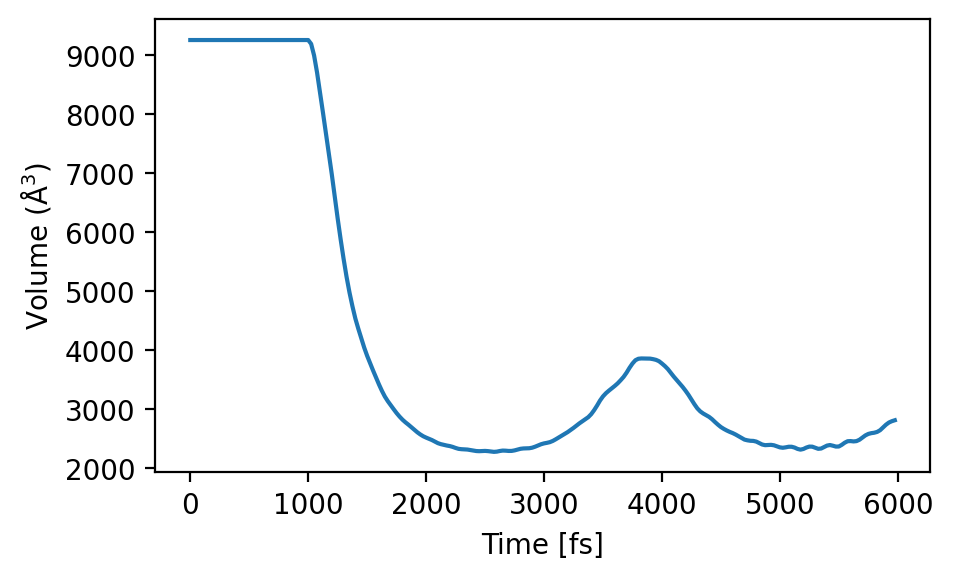

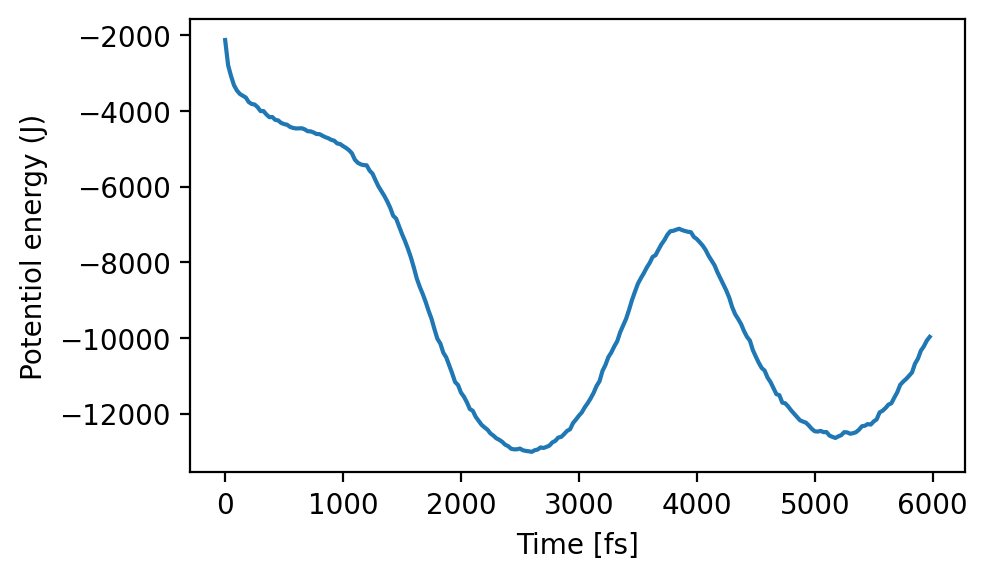

In [13]:
# pyplot.figure(figsize=(8,4), dpi=100)
fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,1]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Volume (Å$^3$)')
plt.show()
fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,5]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Potentiol energy (J)')
plt.show()




** starting run **
Time 00:03:06 | Step 12601 / 22000 | TPS 60.0069 | ETA 00:02:36
Time 00:03:16 | Step 13213 / 22000 | TPS 61.1703 | ETA 00:02:23
Time 00:03:26 | Step 13827 / 22000 | TPS 61.3369 | ETA 00:02:13
Time 00:03:36 | Step 14435 / 22000 | TPS 60.7441 | ETA 00:02:04
Time 00:03:46 | Step 15039 / 22000 | TPS 60.3873 | ETA 00:01:55
Time 00:03:56 | Step 15632 / 22000 | TPS 59.2825 | ETA 00:01:47
Time 00:04:06 | Step 16223 / 22000 | TPS 59.038 | ETA 00:01:37
Time 00:04:16 | Step 16823 / 22000 | TPS 59.983 | ETA 00:01:26
Time 00:04:26 | Step 17427 / 22000 | TPS 60.3507 | ETA 00:01:15
Time 00:04:36 | Step 18033 / 22000 | TPS 60.5597 | ETA 00:01:05
Time 00:04:46 | Step 18643 / 22000 | TPS 60.9574 | ETA 00:00:55
Time 00:04:56 | Step 19244 / 22000 | TPS 59.9597 | ETA 00:00:45
Time 00:05:06 | Step 19836 / 22000 | TPS 59.1676 | ETA 00:00:36
Time 00:05:16 | Step 20418 / 22000 | TPS 58.146 | ETA 00:00:27
Time 00:05:26 | Step 20994 / 22000 | TPS 57.3882 | ETA 00:00:17
Time 00:05:36 | Step 215

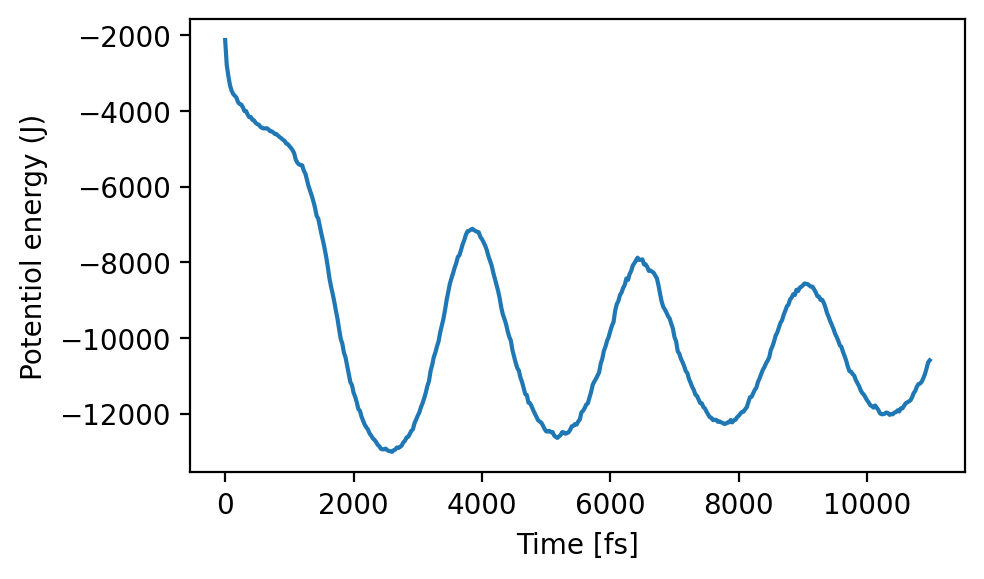

In [14]:
hoomd.run(10000)

data = np.genfromtxt(fname=log_filename, skip_header=True)
fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,5]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Potentiol energy (J)')
plt.show()


** starting run **
Time 00:06:09 | Step 22589 / 32000 | TPS 58.8272 | ETA 00:02:39
Time 00:06:19 | Step 23182 / 32000 | TPS 59.2616 | ETA 00:02:28
Time 00:06:29 | Step 23785 / 32000 | TPS 60.2282 | ETA 00:02:16
Time 00:06:39 | Step 24374 / 32000 | TPS 58.8583 | ETA 00:02:09
Time 00:06:49 | Step 24959 / 32000 | TPS 58.2448 | ETA 00:02:00
Time 00:06:59 | Step 25531 / 32000 | TPS 57.1996 | ETA 00:01:53
Time 00:07:09 | Step 26106 / 32000 | TPS 57.4589 | ETA 00:01:42
Time 00:07:19 | Step 26685 / 32000 | TPS 57.8676 | ETA 00:01:31
Time 00:07:29 | Step 27276 / 32000 | TPS 59.0688 | ETA 00:01:19
Time 00:07:39 | Step 27868 / 32000 | TPS 59.138 | ETA 00:01:09
Time 00:07:49 | Step 28478 / 32000 | TPS 60.9593 | ETA 00:00:57
Time 00:07:59 | Step 29071 / 32000 | TPS 59.226 | ETA 00:00:49
Time 00:08:09 | Step 29668 / 32000 | TPS 59.5514 | ETA 00:00:39
Time 00:08:19 | Step 30254 / 32000 | TPS 58.571 | ETA 00:00:29
Time 00:08:29 | Step 30832 / 32000 | TPS 57.7394 | ETA 00:00:20
Time 00:08:39 | Step 313

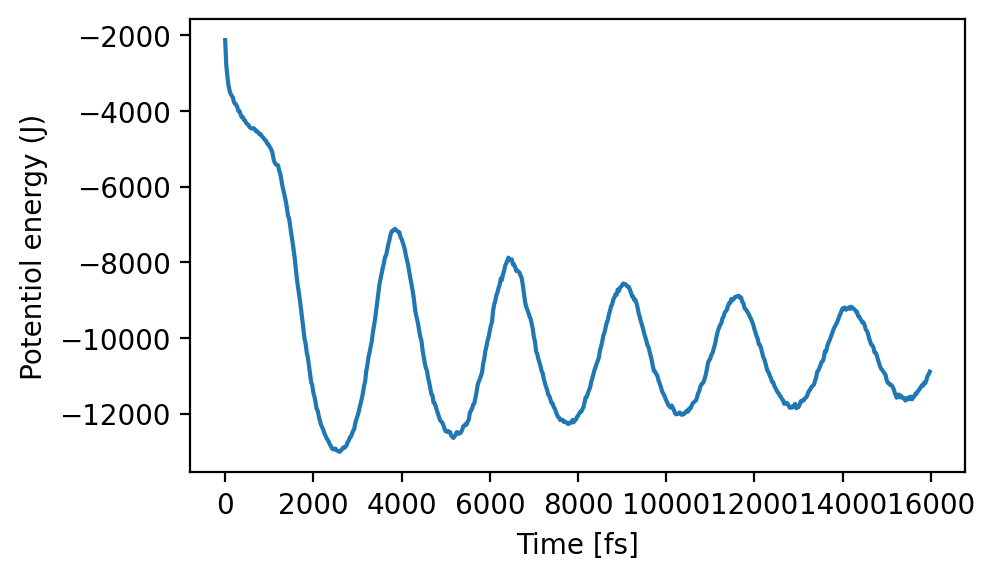

In [15]:
hoomd.run(10000)

data = np.genfromtxt(fname=log_filename, skip_header=True)
fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,5]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Potentiol energy (J)')
plt.show()


** starting run **
Time 00:10:04 | Step 32593 / 102000 | TPS 59.2449 | ETA 00:19:31
Time 00:10:14 | Step 33198 / 102000 | TPS 60.3273 | ETA 00:19:00
Time 00:10:24 | Step 33810 / 102000 | TPS 61.1767 | ETA 00:18:34
Time 00:10:34 | Step 34418 / 102000 | TPS 60.7498 | ETA 00:18:32
Time 00:10:44 | Step 35016 / 102000 | TPS 59.7395 | ETA 00:18:41
Time 00:10:54 | Step 35614 / 102000 | TPS 59.7497 | ETA 00:18:31
Time 00:11:04 | Step 36209 / 102000 | TPS 59.4223 | ETA 00:18:27
Time 00:11:14 | Step 36810 / 102000 | TPS 60.0592 | ETA 00:18:05
Time 00:11:24 | Step 37425 / 102000 | TPS 61.4641 | ETA 00:17:30
Time 00:11:34 | Step 38049 / 102000 | TPS 62.3636 | ETA 00:17:05
Time 00:11:44 | Step 38670 / 102000 | TPS 62.0256 | ETA 00:17:01
Time 00:11:54 | Step 39290 / 102000 | TPS 61.9725 | ETA 00:16:51
Time 00:12:04 | Step 39899 / 102000 | TPS 60.834 | ETA 00:17:00
Time 00:12:14 | Step 40502 / 102000 | TPS 60.2336 | ETA 00:17:00
Time 00:12:24 | Step 41111 / 102000 | TPS 60.8902 | ETA 00:16:39
Time 00

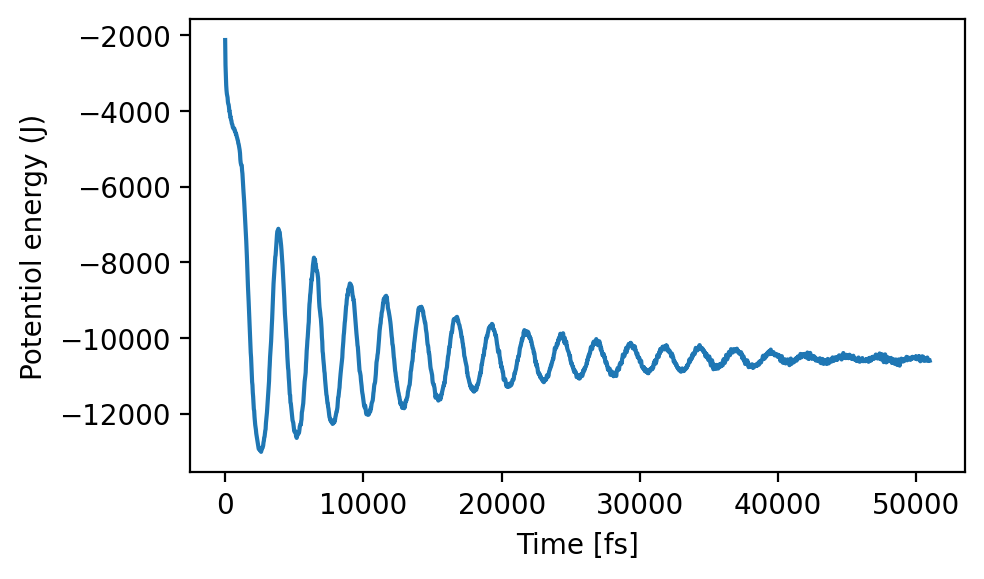

In [16]:

hoomd.run(70000)

data = np.genfromtxt(fname=log_filename, skip_header=True)
fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,5]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Potentiol energy (J)')
plt.show()



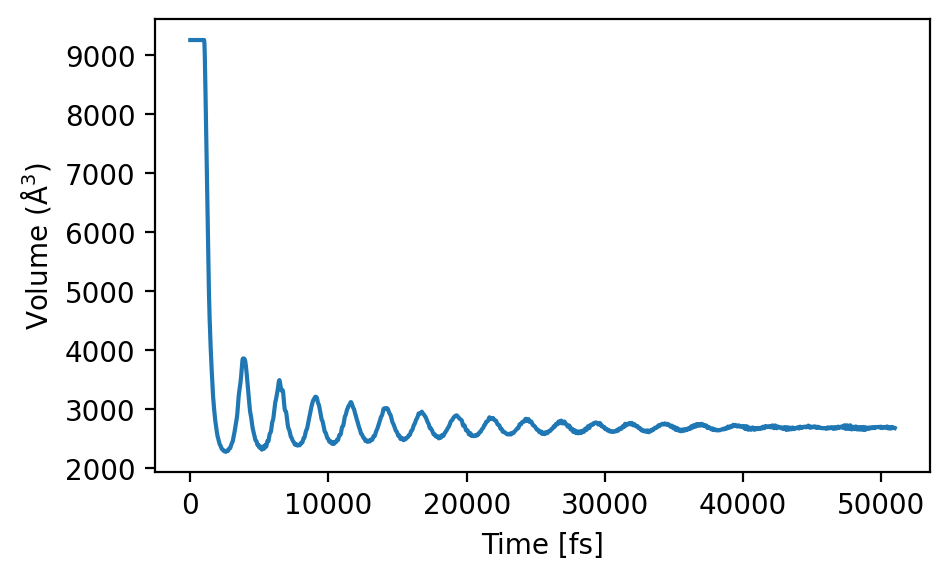

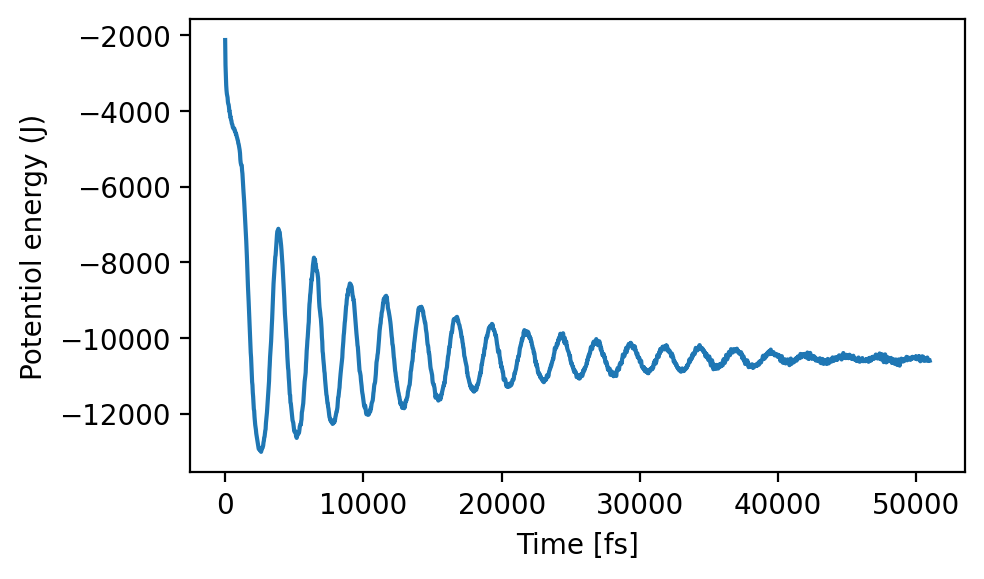

In [19]:
data = np.genfromtxt(fname=log_filename, skip_header=True)
fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,1]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Volume (Å$^3$)')
plt.show()

fig=plt.figure(num=None,figsize=(5,3),dpi=200,facecolor='w',edgecolor='k')
pyplot.plot(data[:,0]*0.5,data[:,5]) # convert timestep to time
pyplot.xlabel('Time [fs]')
pyplot.ylabel('Potentiol energy (J)')
plt.show()
# vol coverges to around 2800-3000 A 
#PE converges to around -100000

If you still see a systematic change in the volume or the energy, thus not yet reached the phase where these quantities fluctuate around an average value, you need to continue the simulation a bit longer! Execute the command `hoomd.run(10000)` again until you're satisfied the system reached equilibrium. In a markdown cell, briefly discuss the outcome of your equilibration protocol with specific reference to the graphs you have generated. </div>